# Target and Feature Selection

So far, we have only run classifaction models on one set of features seeking to find one target variable. Going forward, we will test a few different arrangements of features and targets.

In [1]:
from imports import *

In [52]:
df = pd.read_csv('data/cleaned_df.csv')
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.columns = dummies_df.columns.str.replace(' ','_')
#dummies_df.info()

There are a large number of potential features in this dataset, as well as 3 potential targets: Arrested, Legal_Action_Taken, and Physical_Arrest. In the [previous notebook](./terry_models.ipynb) we only attempted to find Physical Arrests using all the data that existed.

The first thing we do is see if there are better results with each of our other target variables, using Machine Learning Pipelines to streamline the workflow.

We will once again test our data with and without SMOTE since the change in target variables has changed how imbalanced the data is (in this case, it is LESS imbalanced).

In [3]:
clf_forest = RandomForestClassifier(random_state=42)
clf_logreg = LogisticRegression(random_state=42, max_iter=1000)
clf_xgb = XGBClassifier(random_state=42)

logreg_param = {}
logreg_param['classifier__C'] = np.logspace(-2, 2, 10)
logreg_param['classifier__penalty'] = ['l1', 'l2']
logreg_param['classifier'] = [clf_logreg]


forest_param = {}
forest_param['classifier__n_estimators'] = [10,100,1000]
forest_param['classifier__max_depth'] = [None, 3, 4, 10]
forest_param['classifier__max_features'] = ['sqrt', 'log2', 2, 5, 10],
forest_param['classifier'] = [clf_forest]

xgb_param = {}
xgb_param['classifier__n_estimators'] = [10,100,1000]
xgb_param['classifier__learning_rate'] = [0.001, 0.01, 0.1]
xgb_param['classifier__subsample'] =  [0.7]
xgb_param['classifier__max_depth'] = [9]
xgb_param['classifier'] = [clf_xgb]

In [4]:
#pipelines (SMOTE and non SMOTE)
pipeline = imbpipeline([('classifier', LogisticRegression())])

smote_pipeline = imbpipeline([('sm', SMOTE(random_state = 42)),('classifier', LogisticRegression())])

### Target: Arrested (Without Synthetic Data)

In [5]:
# remove other targets
dummies_df.drop(['Physical_Arrest', 'Legal_Action_Taken'], axis=1, inplace=True)

#prepare data
X= dummies_df.drop('Arrested', axis=1)
y = dummies_df['Arrested']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

params = [logreg_param, forest_param, xgb_param]

arrested_cv = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')

arrested_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  3.0min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            random_state=42)],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                          'clas...
                                                       n_estimators=1000,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                           

In [6]:
arrested_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.1,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 1000,
#  'classifier__subsample': 0.7}

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=1000, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 1000,
 'classifier__subsample': 0.7}

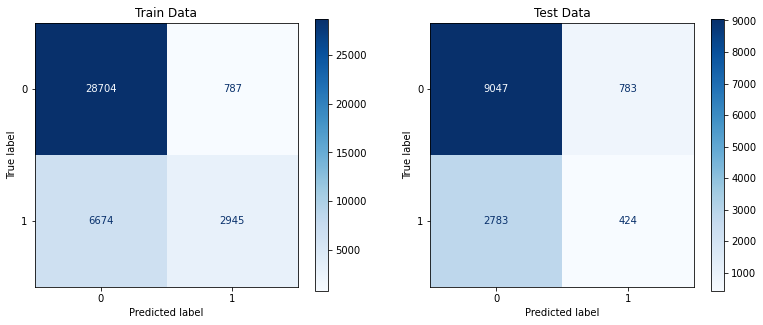

Train Data:                                 Test Data:
Accuracy:  0.8092303758629507               Accuracy:  0.7264708138375393
Recall:    0.30616488200436637              Recall:    0.1322107888992828
Precision: 0.7891211146838156               Precision: 0.3512841756420878
F1:        0.4411654557711033               F1:        0.19211599456275485


In [7]:
plot_confusion(arrested_cv, X_train, X_test, y_train, y_test)
clf_scores(arrested_cv, X_train, X_test, y_train, y_test)

# Train Data:                                 Test Data:
# Accuracy:  0.8092303758629507               Accuracy:  0.7264708138375393
# Recall:    0.30616488200436637              Recall:    0.1322107888992828
# Precision: 0.7891211146838156               Precision: 0.3512841756420878
# F1:        0.4411654557711033               F1:        0.19211599456275485

### Target: Arrested (With Synthetic Data)

In [8]:
params = [logreg_param, forest_param, xgb_param]

arrested_smote_cv = GridSearchCV(smote_pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')

arrested_smote_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  4.5min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            random_state=42)],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381...
                                                       n_estimators=10,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                

In [9]:
arrested_smote_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.1,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 10,
#  'classifier__subsample': 0.7}

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=10, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 10,
 'classifier__subsample': 0.7}

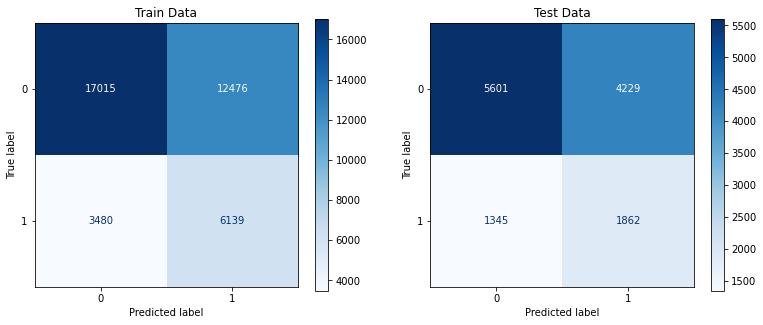

Train Data:                                 Test Data:
Accuracy:  0.5920225006392227               Accuracy:  0.5724476489990028
Recall:    0.6382160307724296               Recall:    0.5806049267227938
Precision: 0.32978780553317216              Precision: 0.3056969298965687
F1:        0.43486576468088123              F1:        0.40051624005162395


In [10]:
plot_confusion(arrested_smote_cv, X_train, X_test, y_train, y_test)
clf_scores(arrested_smote_cv, X_train, X_test, y_train, y_test)

# Train Data:                                 Test Data:
# Accuracy:  0.5920225006392227               Accuracy:  0.5724476489990028
# Recall:    0.6382160307724296               Recall:    0.5806049267227938
# Precision: 0.32978780553317216              Precision: 0.3056969298965687
# F1:        0.43486576468088123              F1:        0.40051624005162395

### Target: Legal Action Taken (Without Synthetic Data)

In [11]:
#remove other targets
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.drop(['Physical_Arrest', 'Arrested'], axis=1, inplace=True)

#prepare dataset
X= dummies_df.drop('Legal_Action_Taken', axis=1)
y = dummies_df['Legal_Action_Taken']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

params = [logreg_param, forest_param, xgb_param]
legal_cv = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')

legal_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  2.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            random_state=42)],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                          'clas...
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
                            

In [12]:
legal_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.001,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 100,
#  'classifier__subsample': 0.7}

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.001, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None),
 'classifier__learning_rate': 0.001,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 100,
 'classifier__subsample': 0.7}

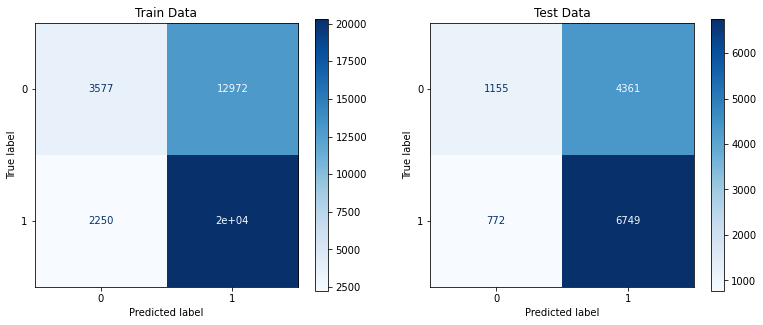

Train Data:                                 Test Data:
Accuracy:  0.6107900792636154               Accuracy:  0.6062744496433229
Recall:    0.9002703780860778               Recall:    0.89735407525595
Precision: 0.610251479734399                Precision: 0.6074707470747075
F1:        0.727419239309505                F1:        0.724491438999517


In [13]:
plot_confusion(legal_cv, X_train, X_test, y_train, y_test)
clf_scores(legal_cv, X_train, X_test, y_train, y_test)

### Target: Legal Action Taken (With Synthetic Data)

In [14]:
params = [logreg_param, forest_param, xgb_param]

legal_smote_cv = GridSearchCV(smote_pipeline, params, cv=3, n_jobs=-1, verbose=True, scoring='f1')

legal_smote_cv.fit(X_train, y_train)

Fitting 3 folds for each of 41 candidates, totalling 123 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  3.7min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            random_state=42)],
                          'classifier__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381...
                                                       n_estimators=1000,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=42,
                                                       reg_alpha=None,
                                                       reg_lambda=None,
              

In [15]:
legal_smote_cv.best_params_

# {'classifier': XGBClassifier()
#  'classifier__learning_rate': 0.01,
#  'classifier__max_depth': 9,
#  'classifier__n_estimators': 1000,
#  'classifier__subsample': 0.7}

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.01, max_delta_step=None, max_depth=9,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=1000, n_jobs=None, num_parallel_tree=None,
               random_state=42, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None),
 'classifier__learning_rate': 0.01,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 1000,
 'classifier__subsample': 0.7}

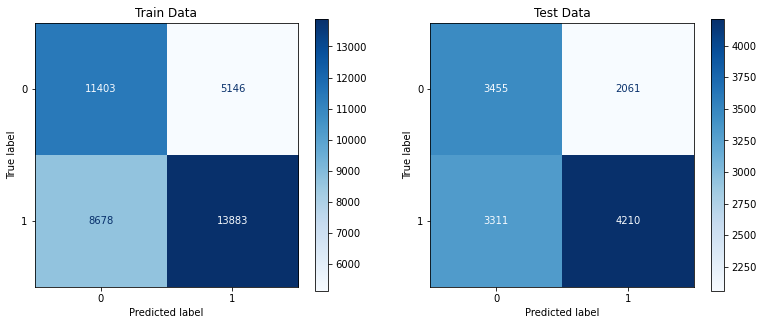

Train Data:                                 Test Data:
Accuracy:  0.6465354129378675               Accuracy:  0.5879420111988954
Recall:    0.6153539293471034               Recall:    0.5597659885653503
Precision: 0.729570655315571                Precision: 0.6713442832084197
F1:        0.6676124068285645               F1:        0.6104988399071926


In [16]:
plot_confusion(legal_smote_cv, X_train, X_test, y_train, y_test)
clf_scores(legal_smote_cv, X_train, X_test, y_train, y_test)

# Train Data:                                 Test Data:
# Accuracy:  0.6465354129378675               Accuracy:  0.5879420111988954
# Recall:    0.6153539293471034               Recall:    0.5597659885653503
# Precision: 0.729570655315571                Precision: 0.6713442832084197
# F1:        0.6676124068285645               F1:        0.6104988399071926

Our most successful model so far: XG Boost testing for Legal Action Taken, without synthetic data (legal_cv), has an F1 score of 0.72 and an Accuracy score of 0.60 on the test data. These are far from ideal outcomes, but at least show that the classifier is better trained than previous models.

## Feature Analysis

The classification models trained with different target variables had significantly different scores, all much better than when the target variable was simply the "Physical Arrest" column.

So far, however, these models have been trained on every single piece of data in the dataset, with the exception of those that we removed in cleaning. There are two issues with this. 

First, some of this data could be meaningless to our classifiers, or even worse, generating noise that can cause our model to underperform or overfit.

Second, there is a limitation on how much real world information we can take away from training models on the entire dataset. If we want to test the predictions of a model based on Subject demographcis alone, for example, then we would want to remove the demographics for the Officer.

### Checking least important features

Next we want see what features could be generating noise in the data, using Lasso Regression to indicate which features have the lowest coefficients.

In [17]:
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.drop(['Physical_Arrest', 'Arrested'], axis=1, inplace=True)

<AxesSubplot:>

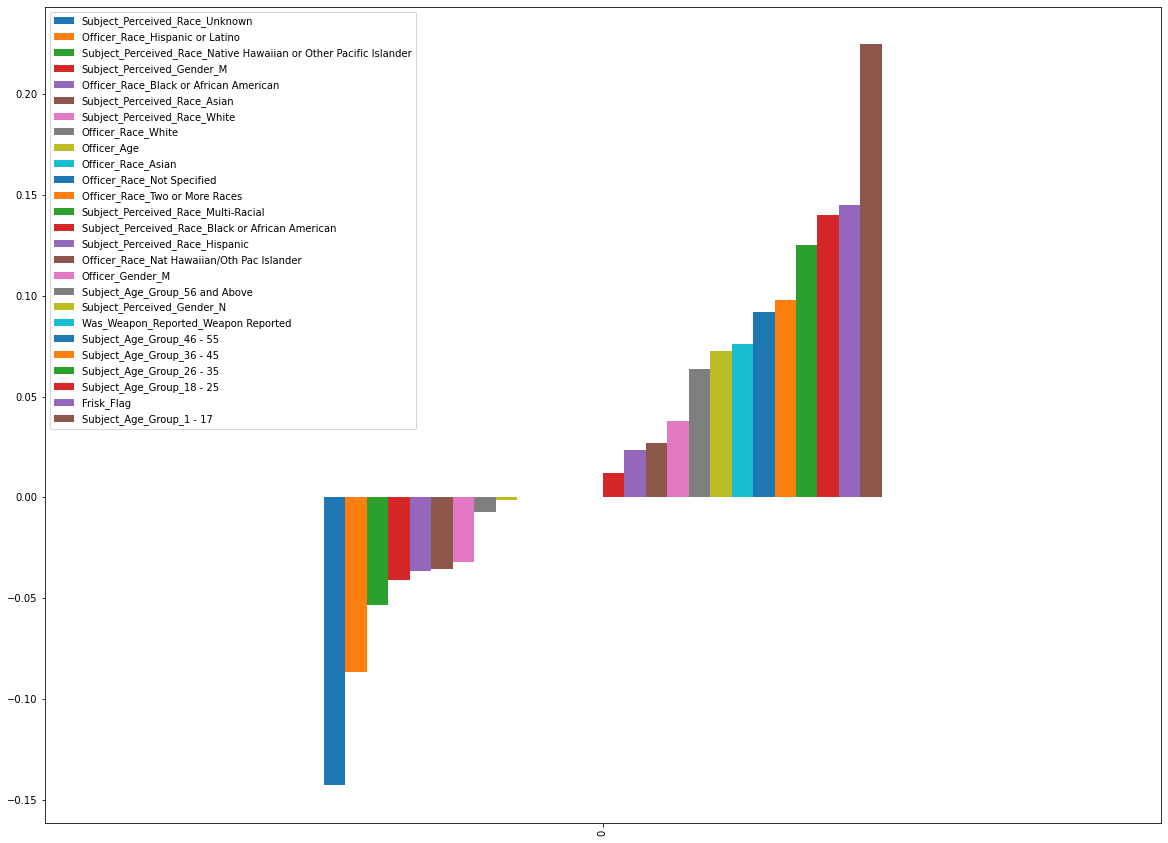

In [18]:
#prepare data
X= dummies_df.drop('Legal_Action_Taken', axis=1)
y = dummies_df['Legal_Action_Taken']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

lasso = Lasso(alpha = 0.0001, normalize = False)
lasso = lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_train)

lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = X_train.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T
lasso_coef.plot(kind='bar', legend=True, figsize=(20,15))

In [19]:
lasso_coef.T

,0
Subject_Perceived_Race_Unknown,-0.142848
Officer_Race_Hispanic or Latino,-0.086521
Subject_Perceived_Race_Native Hawaiian or Other Pacific Islander,-0.053443
Subject_Perceived_Gender_M,-0.041095
Officer_Race_Black or African American,-0.036739
Subject_Perceived_Race_Asian,-0.035310
Subject_Perceived_Race_White,-0.032013
Officer_Race_White,-0.007150
Officer_Age,-0.001085
Officer_Race_Asian,0.000000


We can see by this visualization that specific features are far more impactful on the target, such as "Subject_Age_Group_1 - 17	", and "Subject_Perceived_Race_Unknown".

All the features that have been reduced to 0 have been selected by Lasso as the least significant to the dataset. We will attempt running the model again to see if there is a change in scores.

In [20]:
zero_features = lasso_coef.T.index[lasso_coef.T[0] == 0]
zero_features

Index(['Officer_Race_Asian', 'Officer_Race_Not Specified',
       'Officer_Race_Two or More Races',
       'Subject_Perceived_Race_Multi-Racial'],
      dtype='object')

In [21]:
X_train.drop(zero_features, axis=1, inplace=True)
X_test.drop(zero_features, axis=1, inplace=True)

C:\Users\shade\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
#reduced features classifier
best_xgb = XGBClassifier(learning_rate = 0.01, max_depth = 9, n_estimators = 1000, subsample = 0.7, random_state=42)

best_xgb.fit(X_train, y_train)

#no need for gridsearch, use best params from before

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

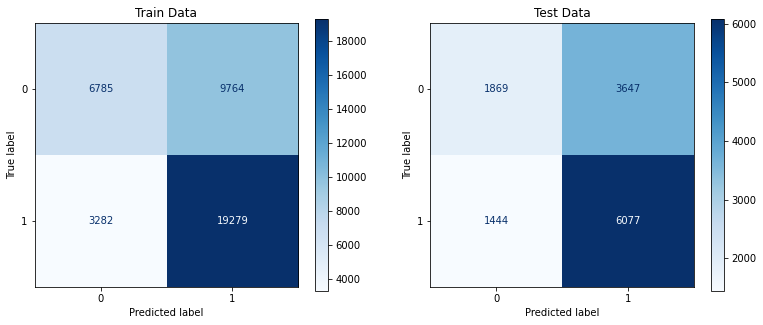

Train Data:                                 Test Data:
Accuracy:  0.6664280235233956               Accuracy:  0.6094960497046866
Recall:    0.854527724834892                Recall:    0.8080042547533572
Precision: 0.6638088351754295               Precision: 0.6249485808309337
F1:        0.7471901402992015               F1:        0.7047839953609742


In [23]:
plot_confusion(best_xgb, X_train, X_test, y_train, y_test)
clf_scores(best_xgb, X_train, X_test, y_train, y_test)

### Explanation of Results

The fact that we did not get any improvement in our model, and in fact caused scores to go down by a small margin, shows that the extraneous data was not causing any issue for our classifier.

Unfortunately, with the current data, it seems unlikely to help our models perform any better with a binary target. This is most likely due to the variability and lack of clarity in very much of the original data. There is clearly potential for more accurate classifiers, but only with more specific data, or perhaps different configurations of the original dataset.

Another potential change that could be made is an adjustment to the type of Classifier. A multiclass or multioutput classifier, or even an unsupervised learning algorithm could find different results, potentially identifying key groups of features that yield different targets.

## Additional Exploratory Analysis of Various Feature Sets

The final tests we will run will be based on specific subsets of features.

### Legal Action: Subject and Officer Demographics

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         52147 non-null  object
 1   Was_Weapon_Reported       52147 non-null  object
 2   Officer_Gender            52147 non-null  object
 3   Officer_Race              52147 non-null  object
 4   Subject_Perceived_Race    52147 non-null  object
 5   Subject_Perceived_Gender  52147 non-null  object
 6   Frisk_Flag                52147 non-null  int64 
 7   Officer_Age               52147 non-null  int64 
 8   Legal_Action_Taken        52147 non-null  int64 
 9   Arrested                  52147 non-null  int64 
 10  Physical_Arrest           52147 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 4.4+ MB


In [67]:
drop_list = ['Physical_Arrest', 'Arrested', 'Was_Weapon_Reported', 'Frisk_Flag']
new_df = df.drop(drop_list, axis=1)
#new_df.info()

new_dummies_df = pd.get_dummies(new_df, drop_first=True)

X= new_dummies_df.drop('Legal_Action_Taken', axis=1)
y = new_dummies_df['Legal_Action_Taken']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
#X_train.info()

legal_demographics = best_xgb.fit(X_train, y_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39110 entries, 39047 to 3910
Data columns (total 24 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   Officer_Age                                                       39110 non-null  int64
 1   Subject_Age_Group_1 - 17                                          39110 non-null  uint8
 2   Subject_Age_Group_18 - 25                                         39110 non-null  uint8
 3   Subject_Age_Group_26 - 35                                         39110 non-null  uint8
 4   Subject_Age_Group_36 - 45                                         39110 non-null  uint8
 5   Subject_Age_Group_46 - 55                                         39110 non-null  uint8
 6   Subject_Age_Group_56 and Above                                    39110 non-null  uint8
 7   Officer_Gender_M                              

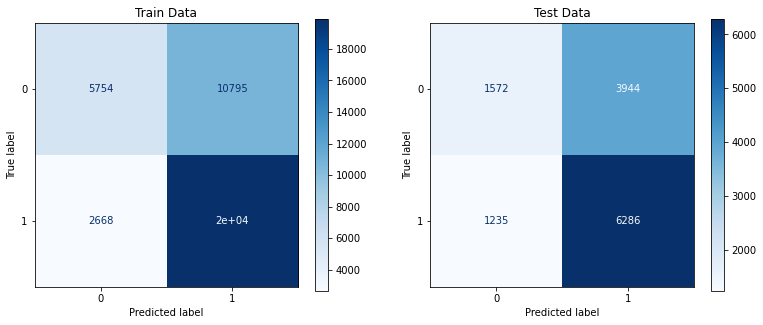

Train Data:                                 Test Data:
Accuracy:  0.6557657888008182               Accuracy:  0.6027460305284958
Recall:    0.8817428305482913               Recall:    0.8357931126180029
Precision: 0.6482338373305526               Precision: 0.6144672531769306
F1:        0.747168960919454                F1:        0.7082417891949749


In [69]:
plot_confusion(legal_demographics, X_train, X_test, y_train, y_test)
clf_scores(legal_demographics, X_train, X_test, y_train, y_test)

### Legal Action: Subject and Officer Demographics - Adjusted Features
For the purposes of this study we will also alter the Officer_Race and Subject_Perceived_Race columns to instead only identify if the Officer or Subject is identified as white, or a minority.

In [71]:
race_adjusted_df = df.drop(['Officer_Race', 'Subject_Perceived_Race'], axis=1)

race_adjusted_df['Officer_Race_White'] = df['Officer_Race'].map(lambda x: 1 if x == 'White' else 0)
race_adjusted_df['Subject_Perceived_Race_White'] = df['Subject_Perceived_Race'].map(lambda x: 1 if x == 'White' else 0)

race_adjusted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Subject_Age_Group             52147 non-null  object
 1   Was_Weapon_Reported           52147 non-null  object
 2   Officer_Gender                52147 non-null  object
 3   Subject_Perceived_Gender      52147 non-null  object
 4   Frisk_Flag                    52147 non-null  int64 
 5   Officer_Age                   52147 non-null  int64 
 6   Legal_Action_Taken            52147 non-null  int64 
 7   Arrested                      52147 non-null  int64 
 8   Physical_Arrest               52147 non-null  int64 
 9   Officer_Race_White            52147 non-null  int64 
 10  Subject_Perceived_Race_White  52147 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 4.4+ MB


In [73]:
drop_list = ['Physical_Arrest', 'Arrested', 'Was_Weapon_Reported', 'Frisk_Flag']
new_df = race_adjusted_df.drop(drop_list, axis=1)
#new_df.info()

new_dummies_df = pd.get_dummies(new_df, drop_first=True)

X= new_dummies_df.drop('Legal_Action_Taken', axis=1)
y = new_dummies_df['Legal_Action_Taken']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
#X_train.info()

legal_demo_adjusted = best_xgb.fit(X_train, y_train)

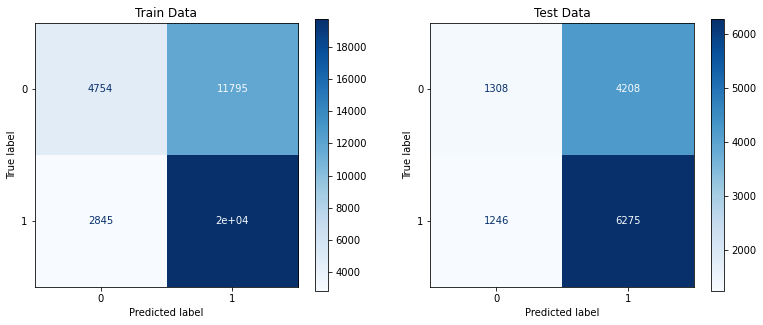

Train Data:                                 Test Data:
Accuracy:  0.6256711838404501               Accuracy:  0.5816522206028995
Recall:    0.8738974336243961               Recall:    0.8343305411514427
Precision: 0.6256862682872648               Precision: 0.5985881904035104
F1:        0.7292498890368398               F1:        0.6970673183736947


In [74]:
plot_confusion(legal_demo_adjusted, X_train, X_test, y_train, y_test)
clf_scores(legal_demo_adjusted, X_train, X_test, y_train, y_test)

## Final Word

As is clear from these tests (and as stated above), there are a vast assortment of possibilities that can be investigated in future analyses. The limitations of a binary target classification algorithm make it challenging to adequately find the results we need to make any sort of substantive reports about the data we have, besides the fact that we need more detailed and standardized data.